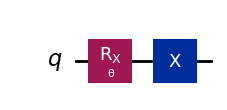

In [1]:
import numpy as np
from qiskit.circuit import QuantumCircuit, Parameter
from gymnasium.spaces import Box
from rl_qoc import (
    CustomPPO,
    ContextAwareQuantumEnvironment,
    RescaleAndClipAction,
    GateTargetConfig,
    QEnvConfig,
    ExecutionConfig,
)
from rl_qoc.environment.configuration.backend_config import QiskitConfig

θ = Parameter("θ")
qc = QuantumCircuit(1)
qc.rx(θ, 0)
qc.x(0)

qc.draw("mpl")

In [2]:
θ_val = 2 * np.pi * 0.1

In [3]:
θ_val

0.6283185307179586

In [4]:
from qiskit_aer.noise import NoiseModel, coherent_unitary_error
from qiskit.circuit.library import RXGate

γ = 0.03
noisy_unitary = RXGate(γ * θ_val).to_matrix()
noise_model = NoiseModel(
    basis_gates=["h", "rx", "rz", "t", "s", "sdg", "tdg", "u", "x", "z"]
)
noise_model.add_all_qubit_quantum_error(coherent_unitary_error(noisy_unitary), "rx")

In [5]:
from qiskit_aer import AerSimulator
from qiskit.providers.fake_provider import GenericBackendV2

backend = GenericBackendV2(
    1,
    ["h", "rx", "rz", "t", "s", "sdg", "tdg", "u", "reset", "x", "z"],
    calibrate_instructions=True,
    control_flow=True,
)
backend = AerSimulator.from_backend(backend, noise_model=noise_model)

In [6]:
# Define target gate
target = GateTargetConfig(physical_qubits=[0], gate="x")

In [7]:
print(backend.target)

Target: Generic Target with 1 qubits
Number of qubits: 1
Instructions:
	h
		(0,):
			Duration: 3.4188e-08 sec.
			Error Rate: 9.57306e-05
			With pulse schedule calibration
	rx
		(0,):
			Duration: 3.5298e-08 sec.
			Error Rate: 9.09703e-05
			With pulse schedule calibration
	rz
		(0,):
			Duration: 0 sec.
			Error Rate: 0
			With pulse schedule calibration
	t
		(0,):
			Duration: 3.0636e-08 sec.
			Error Rate: 9.26541e-05
			With pulse schedule calibration
	s
		(0,):
			Duration: 3.9738e-08 sec.
			Error Rate: 9.3346e-05
			With pulse schedule calibration
	sdg
		(0,):
			Duration: 3.7296e-08 sec.
			Error Rate: 9.96384e-05
			With pulse schedule calibration
	tdg
		(0,):
			Duration: 5.5278e-08 sec.
			Error Rate: 9.66339e-05
			With pulse schedule calibration
	u
		(0,):
			Duration: 3.0858e-08 sec.
			Error Rate: 9.41784e-05
			With pulse schedule calibration
	reset
		(0,):
	x
		(0,):
			Duration: 3.1746e-08 sec.
			Error Rate: 9.83398e-05
			With pulse schedule calibration
	z
		(0,):

In [8]:
# Define parametrized circuit


def apply_parametrized_circuit(qc: QuantumCircuit, params, q_reg, **kwargs):
    my_qc = qc.copy_empty_like(name="x_cal")
    optimal_params = [np.pi]
    new_params = [optimal_params[i] + params[i] for i in range(len(params))]
    my_qc.u(*new_params, -np.pi / 2, np.pi / 2, q_reg[0])

    qc.append(my_qc.to_gate(label=my_qc.name), q_reg)


qiskit_config = QiskitConfig(
    apply_parametrized_circuit,
    backend,
    parametrized_circuit_kwargs={"target": target, "backend": backend},
)

In [9]:
# Define the quantum environment
action_space = Box(low=-0.5, high=0.5, shape=(1,), dtype=np.float32)
env_metadata = {"γ": γ, "θ": θ_val}
training_config = QEnvConfig(
    target=target,
    backend_config=qiskit_config,
    reward_config="channel",
    execution_config=ExecutionConfig(
        batch_size=32, sampling_paulis=100, n_shots=10000, n_reps=9
    ),
    action_space=action_space,
    env_metadata=env_metadata,
)

In [10]:
q_env = ContextAwareQuantumEnvironment(
    training_config, circuit_context=qc.assign_parameters({θ: θ_val})
)
rescaled_env = RescaleAndClipAction(q_env, -1, 1)

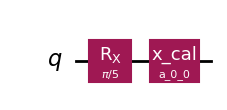

In [11]:
q_env.circuits[0].draw("mpl")

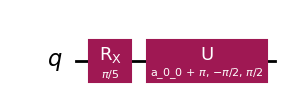

In [12]:
from qiskit import transpile

transpile(q_env.circuits[0], basis_gates=["ry", "rz", "sx", "rx", "u"]).draw("mpl")

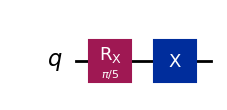

In [19]:
q_env.target.target_circuit.draw("mpl")

Starting simulation benchmark...
Finished simulation benchmark 

Fidelities:  0.9999407841269363
Sending Estimator job...
Finished Estimator job
Reward (avg): 0.9476734885440292 Std: 0.0
Starting simulation benchmark...
Finished simulation benchmark 

Fidelities:  0.9999407841269363
Sending Estimator job...
Finished Estimator job
Reward (avg): 0.9206730289429125 Std: 0.0
Starting simulation benchmark...
Finished simulation benchmark 

Fidelities:  0.9999407841269363
Sending Estimator job...
Finished Estimator job
Reward (avg): 0.9781856754354358 Std: 0.0
Starting simulation benchmark...
Finished simulation benchmark 

Fidelities:  0.9999407841269363
Sending Estimator job...
Finished Estimator job
Reward (avg): 0.9333891254425163 Std: 0.0
Starting simulation benchmark...
Finished simulation benchmark 

Fidelities:  0.9999407841269363
Sending Estimator job...
Finished Estimator job
Reward (avg): 0.9190109279202124 Std: 0.0
Starting simulation benchmark...
Finished simulation benchmark 



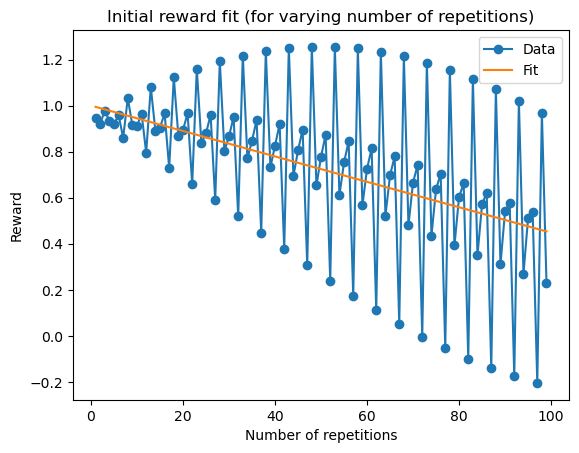

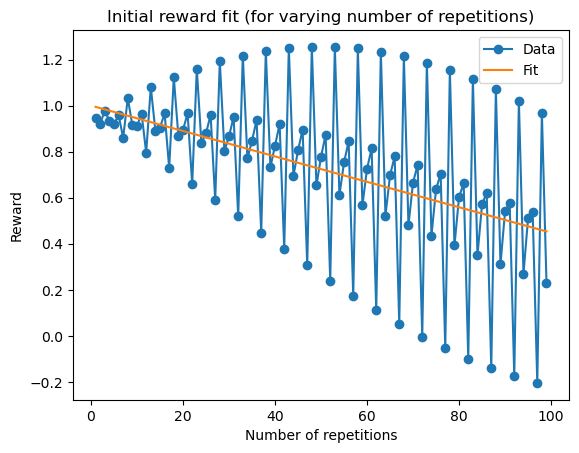

In [13]:
q_env.initial_reward_fit(
    np.zeros((1, 1)),
    execution_config=ExecutionConfig(
        batch_size=1, sampling_paulis=1000, n_shots=1000, n_reps=range(1, 100)
    ),
    update_fit_params=False,
)

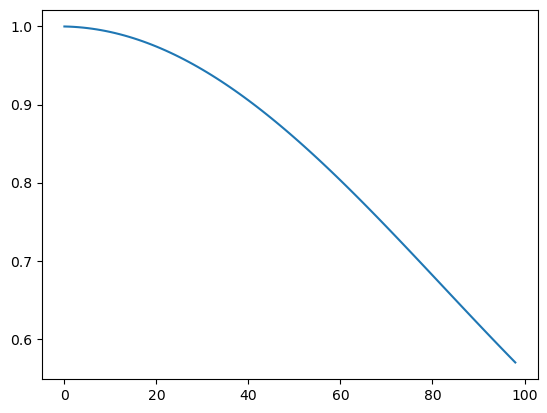

In [41]:
import matplotlib.pyplot as plt

plt.plot(q_env.avg_fidelity_history_nreps)

In [42]:
q_env.config.reward_config.fiducials

[(Pauli('X'),
  [SparsePauliOp(['X'],
                 coeffs=[0.5+0.j])]),
 (Pauli('Y'),
  [SparsePauliOp(['Y'],
                 coeffs=[-0.61803399+0.j]),
   SparsePauliOp(['Z'],
                 coeffs=[0.85065081+0.j])]),
 (Pauli('Z'),
  [SparsePauliOp(['Y'],
                 coeffs=[-0.85065081+0.j]),
   SparsePauliOp(['Z'],
                 coeffs=[-0.61803399+0.j])])]

In [57]:
q_env.target.Chi(4)

array([ 1.00000000e+00,  0.00000000e+00,  2.16006129e-17,  0.00000000e+00,
        0.00000000e+00,  1.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  7.66182000e-01, -6.42623640e-01,
        0.00000000e+00,  0.00000000e+00,  6.42623640e-01,  7.66182000e-01])

In [58]:
q_env.config.reward_config.id_count

0

In [59]:
q_env.config.reward_config.full_fiducials

[([<qiskit.circuit.quantumcircuit.QuantumCircuit at 0x366fc5b10>,
  [SparsePauliOp(['I'],
                 coeffs=[0.5+0.j])]),
 ([<qiskit.circuit.quantumcircuit.QuantumCircuit at 0x3671de090>,
  [SparsePauliOp(['X'],
                 coeffs=[0.5+0.j])]),
 ([<qiskit.circuit.quantumcircuit.QuantumCircuit at 0x367384ed0>,
  [SparsePauliOp(['Z'],
                 coeffs=[0.50000006+0.j])]),
 ([<qiskit.circuit.quantumcircuit.QuantumCircuit at 0x367380590>,
  [SparsePauliOp(['Y'],
                 coeffs=[-0.50000006+0.j])])]

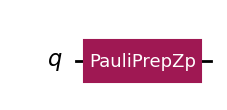

In [60]:
q_env.config.reward_config.full_fiducials[0][0][0].draw("mpl")

Starting simulation benchmark...
Finished simulation benchmark 

Fidelities:  0.9988496511128854
Sending Sampler job...
Finished Sampler job
Reward (avg): 0.9990000000000001 Std: 0.0
Starting simulation benchmark...
Finished simulation benchmark 

Fidelities:  0.9988496511128854
Sending Sampler job...
Finished Sampler job
Reward (avg): 0.99525 Std: 0.0
Starting simulation benchmark...
Finished simulation benchmark 

Fidelities:  0.9988496511128854
Sending Sampler job...
Finished Sampler job
Reward (avg): 0.9862500000000001 Std: 0.0
Starting simulation benchmark...
Finished simulation benchmark 

Fidelities:  0.9988496511128854
Sending Sampler job...
Finished Sampler job
Reward (avg): 0.9765 Std: 0.0
Starting simulation benchmark...
Finished simulation benchmark 

Fidelities:  0.9988496511128854
Sending Sampler job...
Finished Sampler job
Reward (avg): 0.97325 Std: 0.0
Starting simulation benchmark...
Finished simulation benchmark 

Fidelities:  0.9988496511128854
Sending Sampler job...

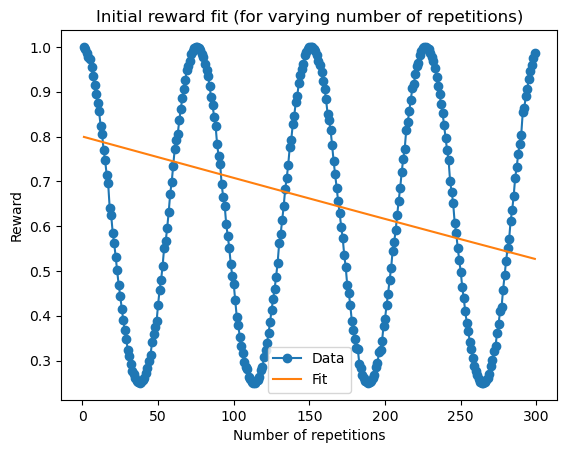

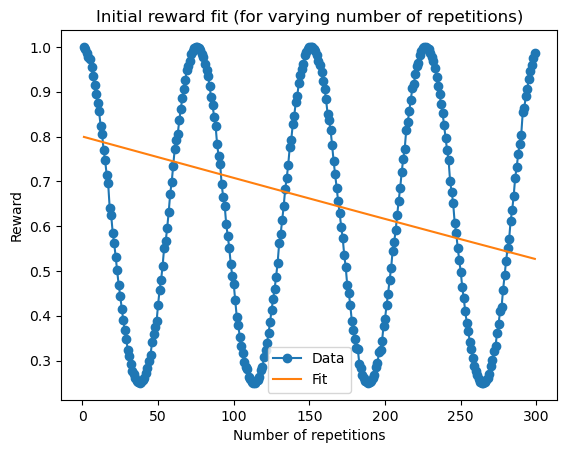

In [15]:
q_env.initial_reward_fit(
    np.zeros((1, 1)),
    execution_config=ExecutionConfig(
        batch_size=1, sampling_paulis=100, n_shots=1000, n_reps=range(1, 300)
    ),
    reward_method="cafe",
    update_fit_params=False,
)

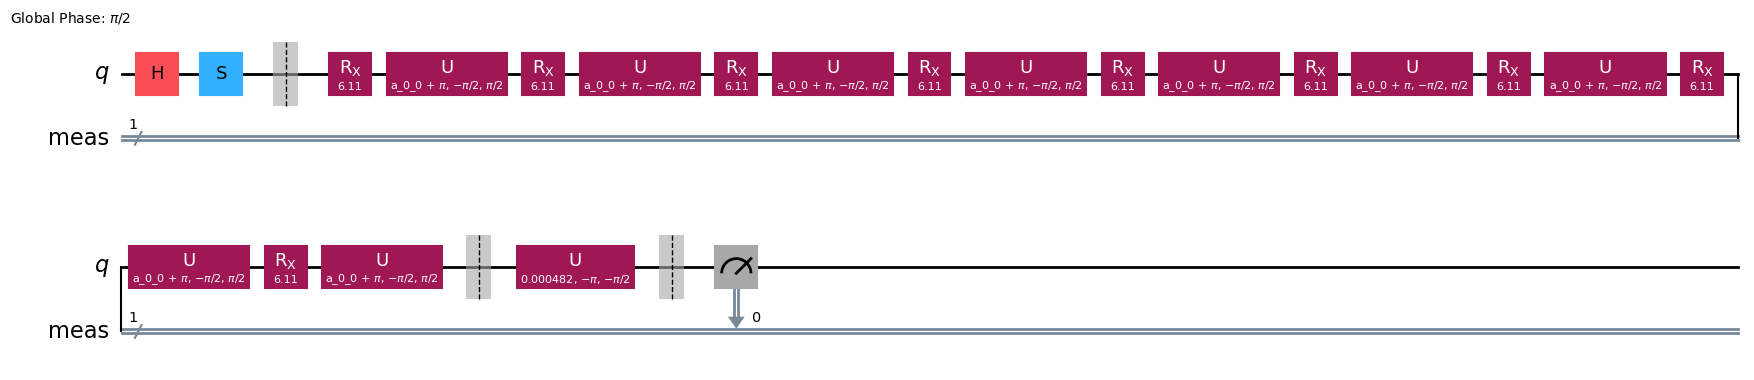

In [73]:
q_env.pubs[3].circuit.draw("mpl")

In [77]:
q_env.pubs[4].observables

ObservablesArray({'Y': 0.534162502924308, 'Z': 1.4209348572348384}, shape=())

In [153]:
from rl_qoc.agent import PPOConfig

ppo_config = PPOConfig.from_yaml("agent_config.yaml")

In [154]:
from rl_qoc.agent import TrainingConfig, TrainFunctionSettings, TotalUpdates

ppo_agent = CustomPPO(ppo_config, rescaled_env, save_data=False)

In [155]:
total_updates = 5
target_fidelities = [0.999]
lookback_window = 20
anneal_learning_rate = True

run_config = TrainingConfig(
    TotalUpdates(total_updates),
    target_fidelities,
    lookback_window,
    anneal_learning_rate,
)
train_settings = TrainFunctionSettings(
    plot_real_time=True,
    print_debug=False,
    num_prints=10,
    hpo_mode=False,
    clear_history=False,
)

In [156]:
print(q_env.backend.target)

Target: Generic Target with 1 qubits
Number of qubits: 1
Instructions:
	h
		(0,):
			Duration: 4.1736e-08 sec.
			Error Rate: 9.49828e-05
			With pulse schedule calibration
	rx
		(0,):
			Duration: 5.5056e-08 sec.
			Error Rate: 9.6191e-05
			With pulse schedule calibration
	rz
		(0,):
			Duration: 0 sec.
			Error Rate: 0
			With pulse schedule calibration
	t
		(0,):
			Duration: 5.3724e-08 sec.
			Error Rate: 9.90911e-05
			With pulse schedule calibration
	s
		(0,):
			Duration: 4.2846e-08 sec.
			Error Rate: 9.78442e-05
			With pulse schedule calibration
	sdg
		(0,):
			Duration: 4.2402e-08 sec.
			Error Rate: 9.97847e-05
			With pulse schedule calibration
	tdg
		(0,):
			Duration: 5.1726e-08 sec.
			Error Rate: 9.05355e-05
			With pulse schedule calibration
	u
		(0,):
			Duration: 3.0192e-08 sec.
			Error Rate: 9.74803e-05
			With pulse schedule calibration
	reset
		(0,):
	delay
		(0,):
	measure
		(0,):
			Duration: 8.34498e-07 sec.
			Error Rate: 0.00167885
			With pulse schedule c

In [157]:
ppo_agent.train(run_config, train_settings)


 Number of repetitions: 9
Starting simulation benchmark...
Finished simulation benchmark 

Fidelities:  0.9990681014632901
Hardware runtime taken: 0.7255887360000001 min  43.53532416 seconds
Sending Estimator job...
Time for running 0.07589411735534668
Finished Estimator job
Reward (avg): 0.24072705715303658 Std: 0.3533584567161784

 Number of repetitions: 9
Starting simulation benchmark...
Finished simulation benchmark 

Fidelities:  0.9995938678878004
Hardware runtime taken: 1.5116432000000002 min  30.698592000000005 seconds
Sending Estimator job...
Time for running 0.038433074951171875
Finished Estimator job
Reward (avg): 0.22423901392478077 Std: 0.33105236612980243

 Number of repetitions: 9
Starting simulation benchmark...
Finished simulation benchmark 

Fidelities:  0.9996714514113081
Hardware runtime taken: 2.317852906666667 min  19.071174400000018 seconds
Sending Estimator job...
Time for running 0.03799700736999512
Finished Estimator job
Reward (avg): 0.3369713332650596 Std: 

{'avg_reward': [0.24072705715303658,
  0.22423901392478077,
  0.3369713332650596,
  0.3633683249098575],
 'fidelity_history': [0.9990681014632901,
  0.9995938678878004,
  0.9996714514113081,
  0.9998297673010769],
 'hardware_runtime': [43.53532416, 47.16326784, 48.3725824, 50.18655424],
 'total_shots': [23040000, 24960000, 25600000, 26560000],
 'total_updates': [],
 'clipped_mean_action_0': [tensor(0.0331),
  tensor(0.0163),
  tensor(0.0090),
  tensor(-0.0048)],
 'mean_action_0': [tensor(0.0662),
  tensor(0.0325),
  tensor(0.0179),
  tensor(-0.0096)],
 'std_action_0': [tensor(0.5183),
  tensor(0.5040),
  tensor(0.4885),
  tensor(0.4739)],
 'clipped_mean_action_1': [tensor(0.0316),
  tensor(0.0035),
  tensor(0.0022),
  tensor(-0.0018)],
 'mean_action_1': [tensor(0.0631),
  tensor(0.0069),
  tensor(0.0045),
  tensor(-0.0036)],
 'std_action_1': [tensor(0.4703),
  tensor(0.4689),
  tensor(0.4684),
  tensor(0.4647)],
 'clipped_mean_action_2': [tensor(0.0241),
  tensor(0.0312),
  tensor(0.02

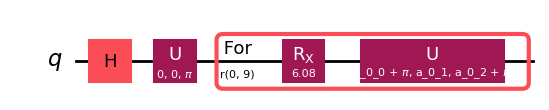

In [26]:
q_env.pubs[0].circuit.draw("mpl")

In [27]:
from qiskit.qasm3 import dumps as qasm_dumps

print(qasm_dumps(q_env.pubs[0].circuit))

OPENQASM 3.0;
include "stdgates.inc";
input float[64] a_0_0;
input float[64] a_0_1;
input float[64] a_0_2;
h $0;
U(0, 0, pi) $0;
for _ in [0:8] {
  rx(6.081253023718493) $0;
  U(a_0_0 + pi, a_0_1, a_0_2 + pi) $0;
}



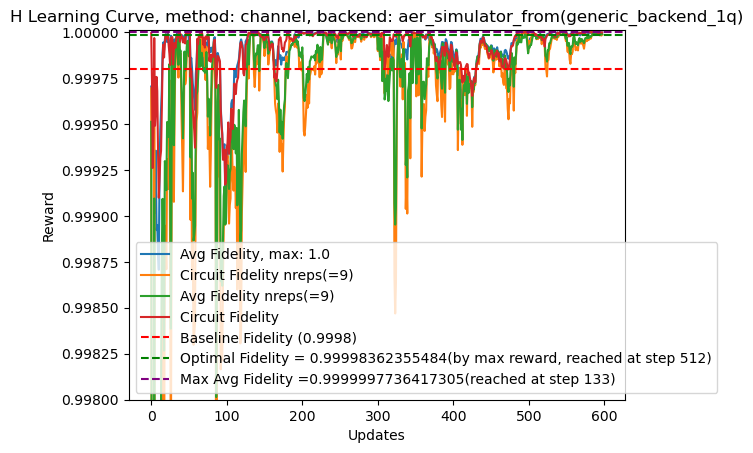

In [115]:
# Plotting the learning curve
import matplotlib.pyplot as plt

reward_history = np.array(q_env.reward_history)
mean_rewards = np.mean(reward_history, axis=-1)
max_mean = np.round(np.max(mean_rewards), 4)
arg_max_mean = np.argmax(mean_rewards)
baseline_fidelity = np.round(
    q_env.simulate_circuit(
        q_env.circuits[0], np.zeros((1, 3)), update_env_history=False
    ),
    4,
)[0]

plot_reward = False
plot_fidelity = True
plot_circuit_fidelity = True
plot_fidelity_nreps = True
plot_circuit_fidelity_nreps = True

if plot_reward:
    plt.plot(mean_rewards, label=f"Reward, max: {max_mean}")
if plot_fidelity:
    plt.plot(
        q_env.fidelity_history,
        label=f"Avg Fidelity, max: {np.round(np.max(q_env.fidelity_history),4)}",
    )
if plot_circuit_fidelity_nreps:
    plt.plot(
        q_env.circuit_fidelity_history_nreps,
        label=f"Circuit Fidelity nreps(={q_env.n_reps})",
    )
if plot_fidelity_nreps:
    plt.plot(
        q_env.avg_fidelity_history_nreps, label=f"Avg Fidelity nreps(={q_env.n_reps})"
    )
if plot_circuit_fidelity:
    plt.plot(q_env.circuit_fidelity_history, label="Circuit Fidelity")
plt.axhline(
    baseline_fidelity,
    label=f"Baseline Fidelity ({baseline_fidelity})",
    color="red",
    linestyle="--",
)
plt.axhline(
    q_env.simulate_circuit(
        q_env.circuits[0], np.array([q_env.optimal_action]), update_env_history=False
    ),
    label=f"Optimal Fidelity = {q_env.fidelity_history[arg_max_mean]}(by max reward, reached at step {arg_max_mean})",
    color="green",
    linestyle="--",
)
plt.axhline(
    np.max(q_env.fidelity_history),
    label=f"Max Avg Fidelity ={np.max(q_env.fidelity_history)}(reached at step {np.argmax(q_env.fidelity_history)})",
    color="purple",
    linestyle="--",
)
plt.xlabel("Updates")
plt.ylabel("Reward")
plt.title(
    f"{q_env.target.gate.name.upper()} Learning Curve, method: {q_env.config.reward_method},"
    f" backend: {q_env.config.backend.name if q_env.config.backend is not None else 'No backend'}"
)
plt.ylim(0.998, 1.00001)
plt.legend()

In [116]:
q_env.optimal_action

array([ 0.00083911, -0.04055472, -0.00375056], dtype=float32)

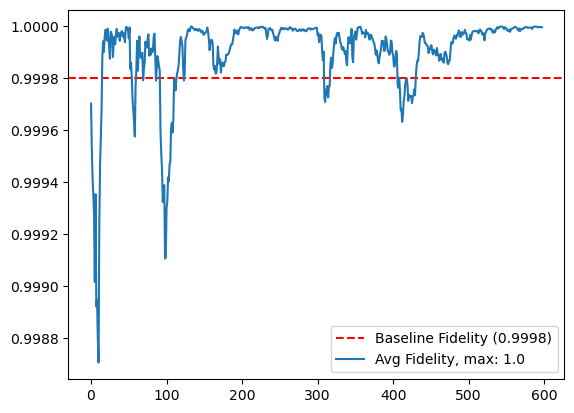

In [117]:
plt.axhline(
    baseline_fidelity,
    label=f"Baseline Fidelity ({baseline_fidelity})",
    color="red",
    linestyle="--",
)
plt.plot(
    q_env.fidelity_history,
    label=f"Avg Fidelity, max: {np.round(np.max(q_env.fidelity_history),4)}",
)
plt.legend()

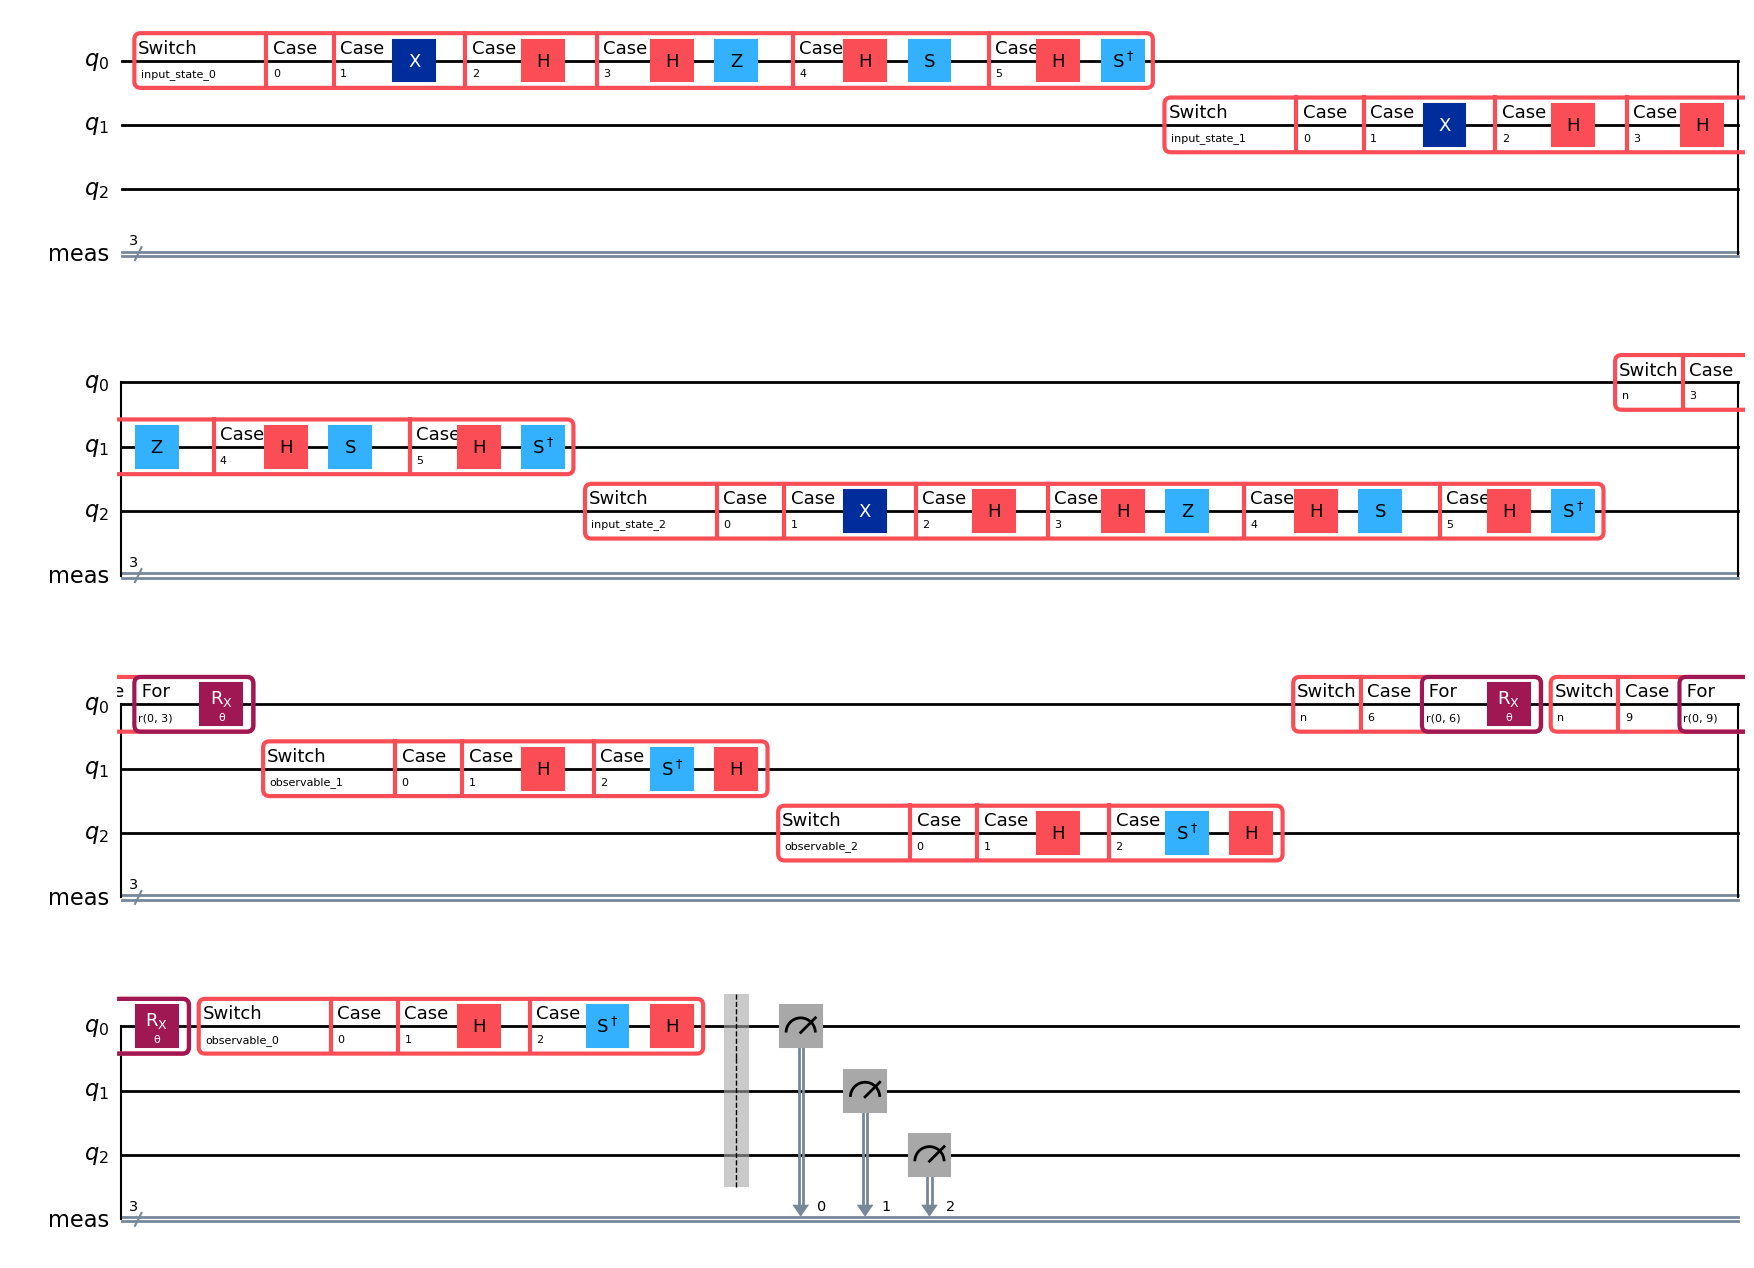

In [37]:
from qiskit.circuit import QuantumCircuit, ClassicalRegister, QuantumRegister, Parameter
from qiskit.circuit.classical.types import Uint, Bool
from qiskit.primitives import StatevectorSampler
from qiskit_aer.primitives import SamplerV2
from qiskit_experiments.library.tomography.basis import (
    Pauli6PreparationBasis,
    PauliMeasurementBasis,
)
import numpy as np

num_qubits = 3
q = QuantumRegister(num_qubits, "q")
qc = QuantumCircuit(q)
θ = Parameter("θ")
input_state = [qc.add_input(f"input_state_{i}", Uint(8)) for i in range(num_qubits)]
observable = [qc.add_input(f"observable_{i}", Uint(8)) for i in range(num_qubits)]
n = qc.add_input("n", Uint(8))
n_reps = [3, 6, 9]
for q_idx, qubit in enumerate(q):
    with qc.switch(input_state[q_idx]) as case:
        for i in range(6):
            with case(i):
                qc.compose(
                    Pauli6PreparationBasis().circuit([i]).decompose(),
                    [qubit],
                    inplace=True,
                )

if len(n_reps) == 1:
    n_ = n_reps[0]
    with qc.for_loop(range(n_)):
        qc.rx(θ, q[0])
else:
    for n_ in n_reps:
        with qc.switch(n) as case:
            with case(n_):
                with qc.for_loop(range(n_)):
                    qc.rx(θ, q[0])
for q_idx, qubit in enumerate(q):
    with qc.switch(observable[q_idx]) as case:
        for i in range(3):
            with case(i):
                qc.compose(
                    PauliMeasurementBasis()
                    .circuit([i])
                    .remove_final_measurements(False)
                    .decompose(),
                    [qubit],
                    inplace=True,
                )

qc.measure_all()

qc.draw("mpl")

In [12]:
from qiskit.circuit import ParameterVector

param_vec = ParameterVector("θ", 3)
param_vec[0].subs({param_vec[0]: 1})

ParameterVector(name='θ', length=3)

In [31]:
from qiskit.qasm3 import dumps as qasm_dumps

print(qasm_dumps(qc))

OPENQASM 3.0;
include "stdgates.inc";
input float[64] θ;
input uint[8] input_state_0;
input uint[8] input_state_1;
input uint[8] input_state_2;
input uint[8] observable_0;
input uint[8] observable_1;
input uint[8] observable_2;
input uint[8] n;
bit[3] meas;
int switch_dummy;
int switch_dummy_0;
int switch_dummy_1;
int switch_dummy_2;
int switch_dummy_3;
int switch_dummy_4;
int switch_dummy_5;
int switch_dummy_6;
int switch_dummy_7;
qubit[3] q;
switch_dummy = input_state_0;
switch (switch_dummy) {
  case 0 {
  }
  case 1 {
    x q[0];
  }
  case 2 {
    h q[0];
  }
  case 3 {
    h q[0];
    z q[0];
  }
  case 4 {
    h q[0];
    s q[0];
  }
  case 5 {
    h q[0];
    sdg q[0];
  }
}
switch_dummy_0 = input_state_1;
switch (switch_dummy_0) {
  case 0 {
  }
  case 1 {
    x q[1];
  }
  case 2 {
    h q[1];
  }
  case 3 {
    h q[1];
    z q[1];
  }
  case 4 {
    h q[1];
    s q[1];
  }
  case 5 {
    h q[1];
    sdg q[1];
  }
}
switch_dummy_1 = input_state_2;
switch (switch_dummy_1) {
  

In [268]:
sampler = SamplerV2()
job = sampler.run([(qc, [0.3, 0.2, 0.1])])
result = job.result()
result

PrimitiveResult([SamplerPubResult(data=DataBin(meas=BitArray(<shape=(3,), num_shots=1024, num_bits=3>), shape=(3,)), metadata={'shots': 1024, 'circuit_metadata': {}, 'simulator_metadata': {'time_taken_parameter_binding': 6.3292e-05, 'max_memory_mb': 18432, 'time_taken_execute': 0.092705291, 'omp_enabled': True, 'max_gpu_memory_mb': 0, 'parallel_experiments': 1}})], metadata={'version': 2})

In [273]:
result[0].data.meas[0]

BitArray(<shape=(), num_shots=1024, num_bits=3>)

In [274]:
result[0].data.meas[0].postselect([0], 0)

BitArray(<shape=(), num_shots=509, num_bits=3>)

In [278]:
result[0].data.meas.get_counts(0)

{'001': 506, '110': 499, '000': 10, '111': 9}

In [201]:
qc.clbits

[Clbit(ClassicalRegister(3, 'meas'), 0),
 Clbit(ClassicalRegister(3, 'meas'), 1),
 Clbit(ClassicalRegister(3, 'meas'), 2)]

In [11]:
from rl_qoc.rewards.real_time import get_real_time_reward_circuit

pub = get_real_time_reward_circuit(
    q_env.circuits[0],
    np.zeros((1, 3)),
    q_env.target,
    q_env.backend_info,
    q_env.config.execution_config,
    q_env.config.reward_method,
)

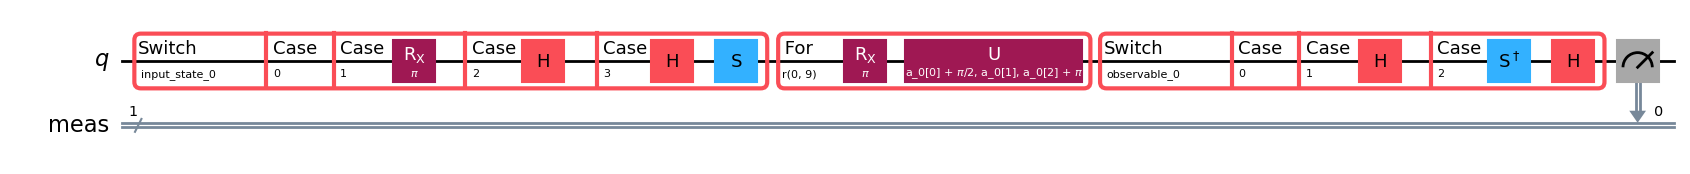

In [12]:
pub.circuit.draw("mpl")

In [15]:
from qiskit.qasm3 import dumps as qasm_dumps

print(qasm_dumps(pub.circuit))

OPENQASM 3.0;
include "stdgates.inc";
input float[64] _a_0_0_;
input float[64] _a_0_1_;
input float[64] _a_0_2_;
input uint[4] observable_0;
input uint[4] input_state_0;
bit[1] meas;
int switch_dummy;
int switch_dummy_0;
switch_dummy = input_state_0;
switch (switch_dummy) {
  case 0 {
  }
  case 1 {
    rx(pi) $0;
  }
  case 2 {
    h $0;
  }
  case 3 {
    h $0;
    s $0;
  }
}
for _ in [0:8] {
  rx(pi) $0;
  U(_a_0_0_ + pi/2, _a_0_1_, _a_0_2_ + pi) $0;
}
switch_dummy_0 = observable_0;
switch (switch_dummy_0) {
  case 0 {
  }
  case 1 {
    h $0;
  }
  case 2 {
    sdg $0;
    h $0;
  }
}
meas[0] = measure $0;

